<a href="https://colab.research.google.com/github/samochristian2020/Data-Science-and-Statistics/blob/main/Project_Image_Classifier_Project002(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, we might want to include an image classifier in a smart phone app. To do this, we'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture.
In this project, we'll train an image classifier to recognize different species of flowers. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories, we can see a few examples below.


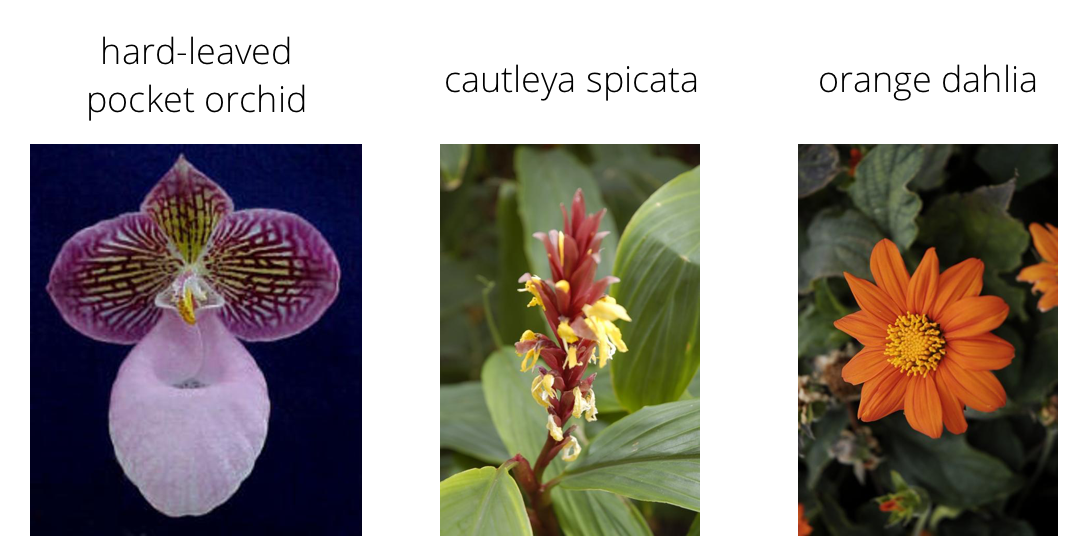

In [3]:
from PIL import Image

im = Image.open('/content/drive/MyDrive/test_images/assets/Flowers.png')
im

The project is broken down into multiple steps:

* Load the image dataset and create a pipeline.
* Build and Train an image classifier on this dataset.
* Use our trained model to perform inference on flower images.

We'll implement this project in Python.



## Import Resources

In [4]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [5]:
import tensorflow as tf
print(tf.__version__)

2.18.0


In [6]:
import tensorflow_datasets as tfds
print(tfds.__version__)

4.9.9


In [7]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt

In [8]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)


## Load the Dataset

Here we'll use `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  we'll also need to make sure the training data is normalized and resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but we'll still need to normalize and resize the images to the appropriate size.

In [9]:
# #: Load the dataset with TensorFlow Datasets.
dataset, dataset_info = tfds.load('oxford_flowers102',
                                  split=['train[:80%]','test[:5%]','test[5%:10%]'],
                                  with_info=True,
                                  as_supervised=True)

# #: Create a training set, a validation set and a test set.
training_set, validation_set, test_set = dataset



Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.D3CNK5_2.1.1/oxford_flowers102-train.tfrecord…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.D3CNK5_2.1.1/oxford_flowers102-test.tfrecord*…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.D3CNK5_2.1.1/oxford_flowers102-validation.tfr…

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


In [10]:
print(dataset_info.description)

The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly
occurring in the United Kingdom. Each class consists of between 40 and 258
images. The images have large scale, pose and light variations. In addition,
there are categories that have large variations within the category and several
very similar categories.

The dataset is divided into a training set, a validation set and a test set. The
training set and validation set each consist of 10 images per class (totalling
1020 images each). The test set consists of the remaining 6149 images (minimum
20 per class).

Note: The dataset by default comes with a test size larger than the train size.
For more info see this
[issue](https://github.com/tensorflow/datasets/issues/3022).


## Explore the Dataset

In [11]:
# #: Get the number of examples in each set from the dataset info.

print('training_set contains {} examples'.format(training_set.cardinality()))
print('validation_set contains {} examples'.format(validation_set.cardinality()))
print('test_set contains {} examples'.format(test_set.cardinality()))



# #: Get the number of classes in the dataset from the dataset info.
print('\n the number of classes in this dataset is :{}'.format(dataset_info.features['label'].num_classes))


training_set contains 816 examples
validation_set contains 307 examples
test_set contains 308 examples

 the number of classes in this dataset is :102


In [12]:
# #: Print the shape and corresponding label of 3 images in the training set.
size_train = training_set.cardinality()
nb = np.random.choice(size_train, 3)
nb
for i, j in enumerate(training_set):
  if i in nb:
    print('shape of image of index :{}, is :{}'.format(i,j[0].shape))

shape of image of index :142, is :(752, 500, 3)
shape of image of index :599, is :(500, 500, 3)
shape of image of index :808, is :(500, 667, 3)


In [13]:
def plot_3images (idx, set):

  f= plt.figure(figsize=(12, 12))
  ax = f.add_subplot(1, 3, 1), f.add_subplot(1, 3, 2), f.add_subplot(1, 3, 3)

  j=0
  if j<3:
    for i, datapoint in enumerate(set):
      if i in idx:
        image, label= datapoint
        image = image.numpy().squeeze()
        label = label.numpy()
        # Plot the image

        ax[j].imshow(image)

        ax[j].set_title('The label of this image is: {}'.format(label))
        j =j + 1
  return None


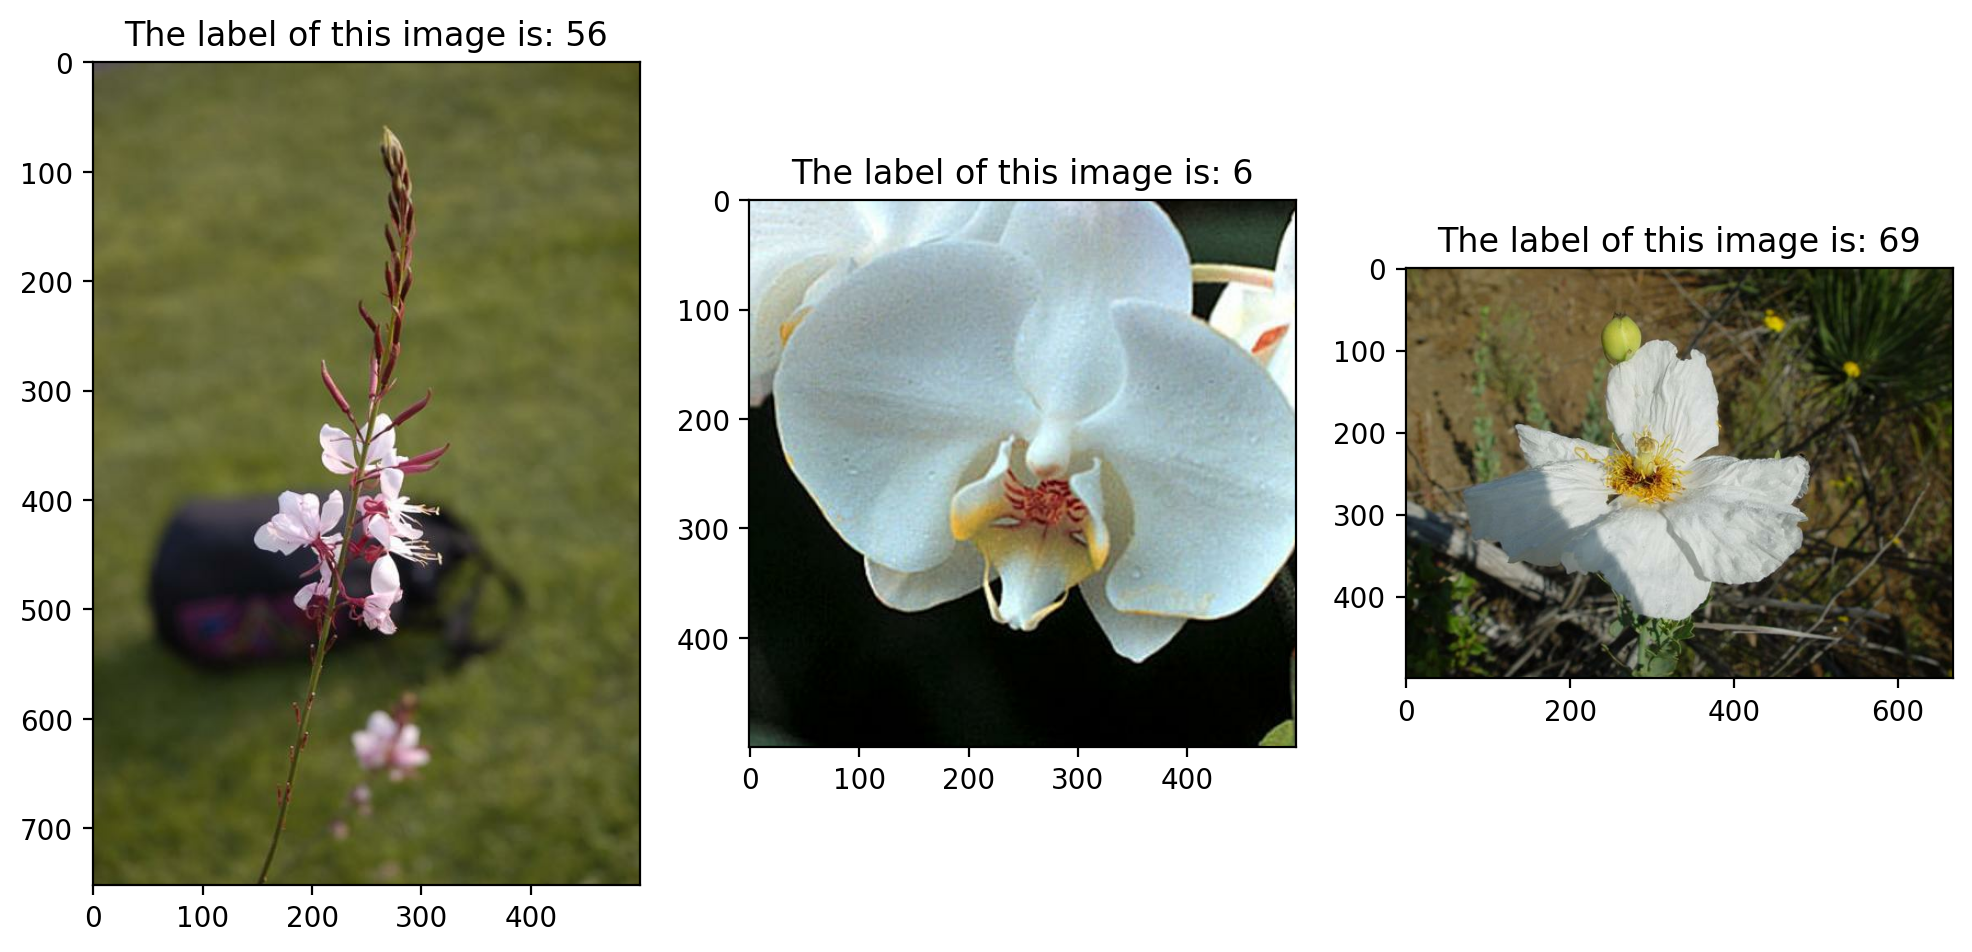

In [14]:
plot_3images(nb, training_set)

### Label Mapping

we'll also need to load in a mapping from label to category name. we can find this in the file `label_map.json`. It's a JSON object which we can read in with the [`json` module](https://docs.python.org/3.7/library/json.html). This will give we a dictionary mapping the integer coded labels to the actual names of the flowers.

In [15]:
import json
with open('/content/drive/MyDrive/label_map.json', 'r') as f:
    class_names = json.load(f)

In [16]:
def plot_3images_names (idx, set):

  f= plt.figure(figsize=(12, 12))
  ax = f.add_subplot(1, 3, 1), f.add_subplot(1, 3, 2), f.add_subplot(1, 3, 3)

  j=0
  if j<3:
    for i, datapoint in enumerate(set):
      if i in idx:
        image, label= datapoint
        image = image.numpy().squeeze()
        label = label.numpy()
        # Plot the image

        ax[j].imshow(image)

        ax[j].set_title('The label of this image is: {}'.format(class_names[str(label)]))
        j =j + 1
  return None


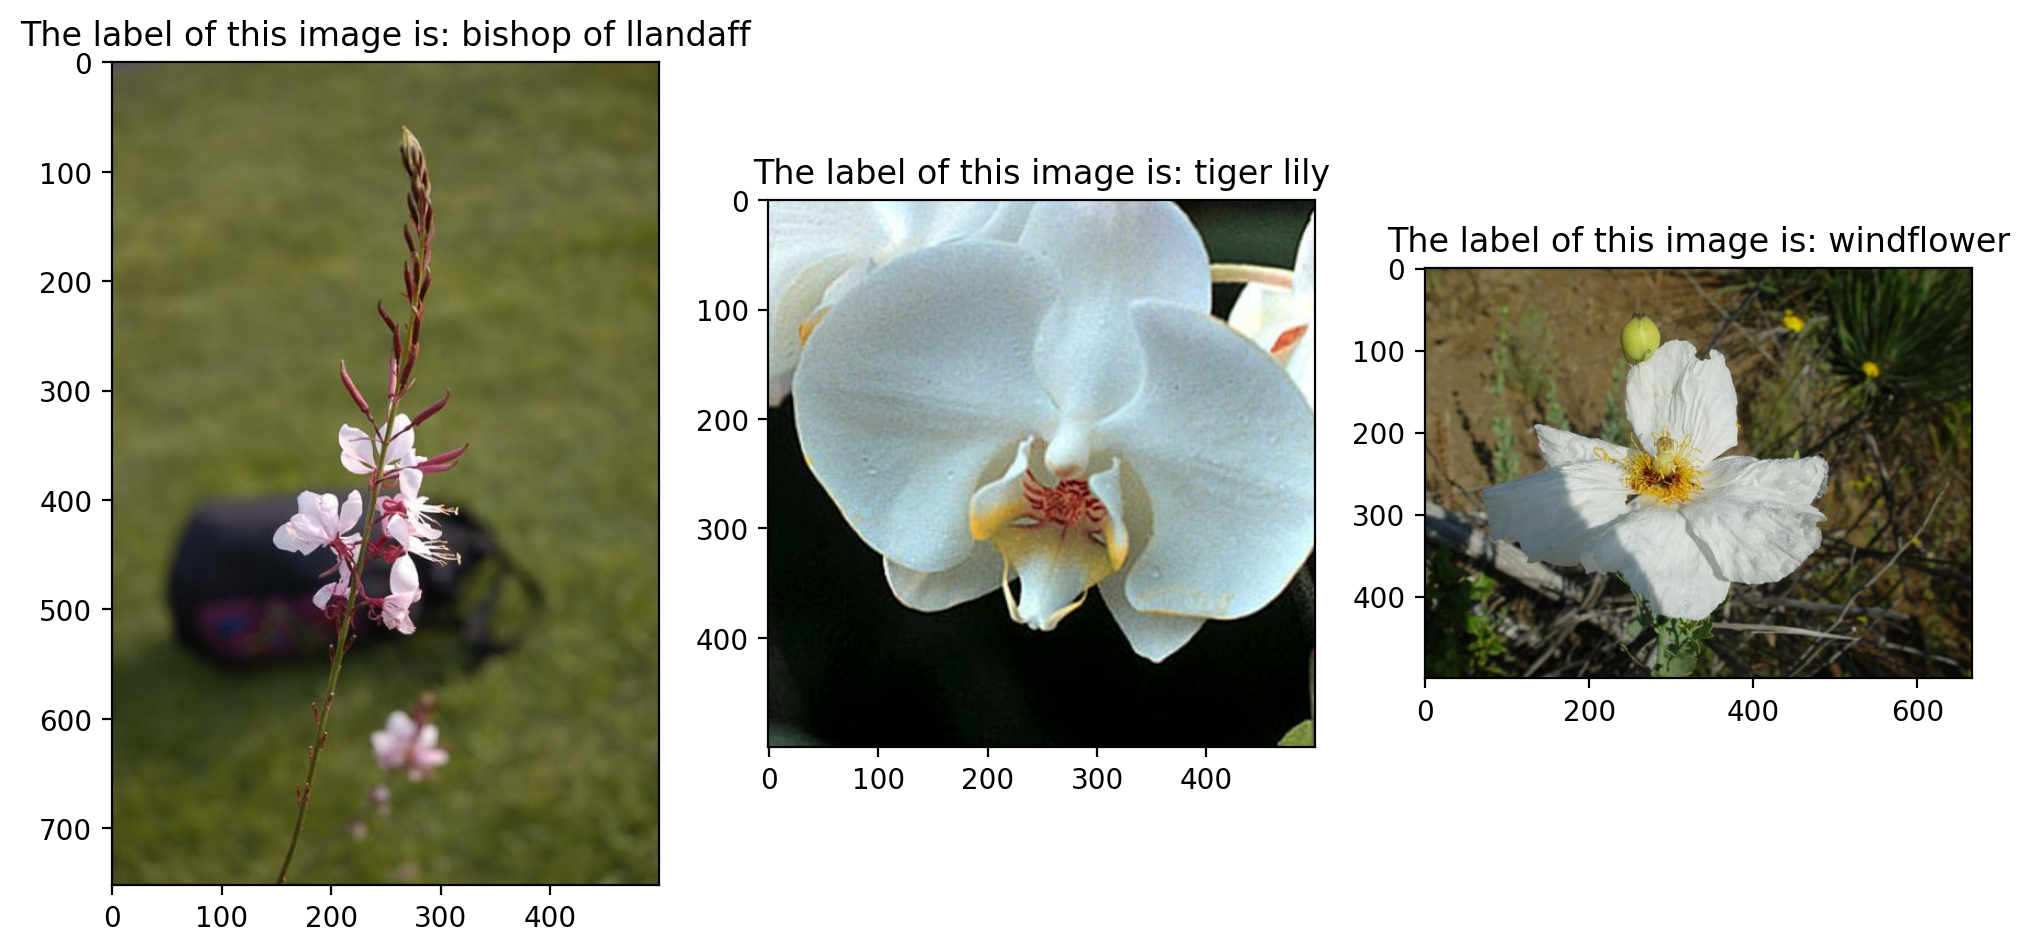

In [17]:
plot_3images_names(nb, training_set)

## Create Pipeline

we'll also need to make sure the training, validation and test data are normalized and resized to 224x224 pixels as required by the pre-trained networks.



In [18]:
import keras
keras.__version__

'3.8.0'

In [19]:
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input #, decode_predictions

In [55]:
from keras import ops
one_hot = keras.layers.CategoryEncoding(num_tokens=102,
                                        output_mode='one_hot')


In [63]:
def normalize_im(image, label):

  image = ops.image.resize(image, (224, 224))
  image = tf.cast(image, tf.float32)
  x = preprocess_input(image)
  label = one_hot(label)
  label = tf.reshape(label, [-1])

  return x, label



In [64]:
from tensorflow import data as tf_data
B=64
nb_train = size_train
train_batches = training_set.cache().shuffle(nb_train//4).map(normalize_im).batch(B).prefetch(tf_data.AUTOTUNE)

validation_batches = validation_set.cache().map(normalize_im).batch(B).prefetch(tf_data.AUTOTUNE)

test_batches = test_set.cache().map(normalize_im).batch(B).prefetch(tf_data.AUTOTUNE)

In [65]:
list(train_batches.take(5))[3][1][10]

<tf.Tensor: shape=(102,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>

# Build and Train the Classifier

Now the data is ready, let's build and train the classifier. we should use the MobileNet pre-trained model from TensorFlow Hub to get the image features. Build and train a new feed-forward classifier using those features.

Things we'll do:

* Load the MobileNet pre-trained network from TensorFlow Hub.
* Define a new, untrained feed-forward network as a classifier.
* Train the classifier.
* Plot the loss and accuracy values achieved during training for the training and validation set.
* Save our trained model as a Keras model.


In [66]:
base_model = MobileNetV2(input_shape=(224,224,3),
                         alpha=1.0,
                         include_top=False,
                         weights="imagenet",
                         input_tensor=None,
                         pooling=None,
                         classes=102,
                         classifier_activation="softmax",
                         name=None,)
base_model.trainable = False
in_data = keras.Input(shape=(224, 224, 3))
inputs = base_model(in_data, training=False)
inputs = keras.layers.GlobalAveragePooling2D()(inputs)
inputs = keras.layers.Dropout(0.2)(inputs)

outputs = keras.layers.Dense(102, activation='softmax')(inputs)
modell =keras.Model(in_data, outputs)

In [67]:
modell.summary(show_trainable=True)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_11 (InputLayer) │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ mobilenetv2_1.00_224        │ (None, 7, 7, 1280)    │  2,257,984 │   N   │
│ (Functional)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_5  │ (None, 1280)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_5 (Dropout)         │ (None, 1280)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_5 (Dense)             │ (None, 102)           │    130,662 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 2,388,646 (9.11 MB)

 Trainable params: 130,662 (510.40 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [68]:
modell.compile(optimizer = keras.optimizers.Adam(),
               loss= keras.losses.CategoricalCrossentropy(),
               metrics=[keras.metrics.CategoricalAccuracy()])

## Train the Top Layer


In [69]:
#fitting the top layer of our model

history = modell.fit(train_batches,
                     epochs=100,
                     validation_data= validation_batches,
                     callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - categorical_accuracy: 0.0152 - loss: 4.9798 - val_categorical_accuracy: 0.1303 - val_loss: 3.9984
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 81ms/step - categorical_accuracy: 0.2513 - loss: 3.4641 - val_categorical_accuracy: 0.3844 - val_loss: 3.1502
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - categorical_accuracy: 0.5606 - loss: 2.4428 - val_categorical_accuracy: 0.5765 - val_loss: 2.5395
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - categorical_accuracy: 0.8236 - loss: 1.6936 - val_categorical_accuracy: 0.6547 - val_loss: 2.1063
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - categorical_accuracy: 0.8800 - loss: 1.2083 - val_categorical_accuracy: 0.6938 - val_loss: 1.8315
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - categorical_accuracy: 0.9348 - loss: 0.8901 - val_categorical_accuracy: 0.7068 - val_loss: 1.6257
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - categorical_accuracy: 0.9491 - los

In [70]:
history.history.keys()


dict_keys(['categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss'])

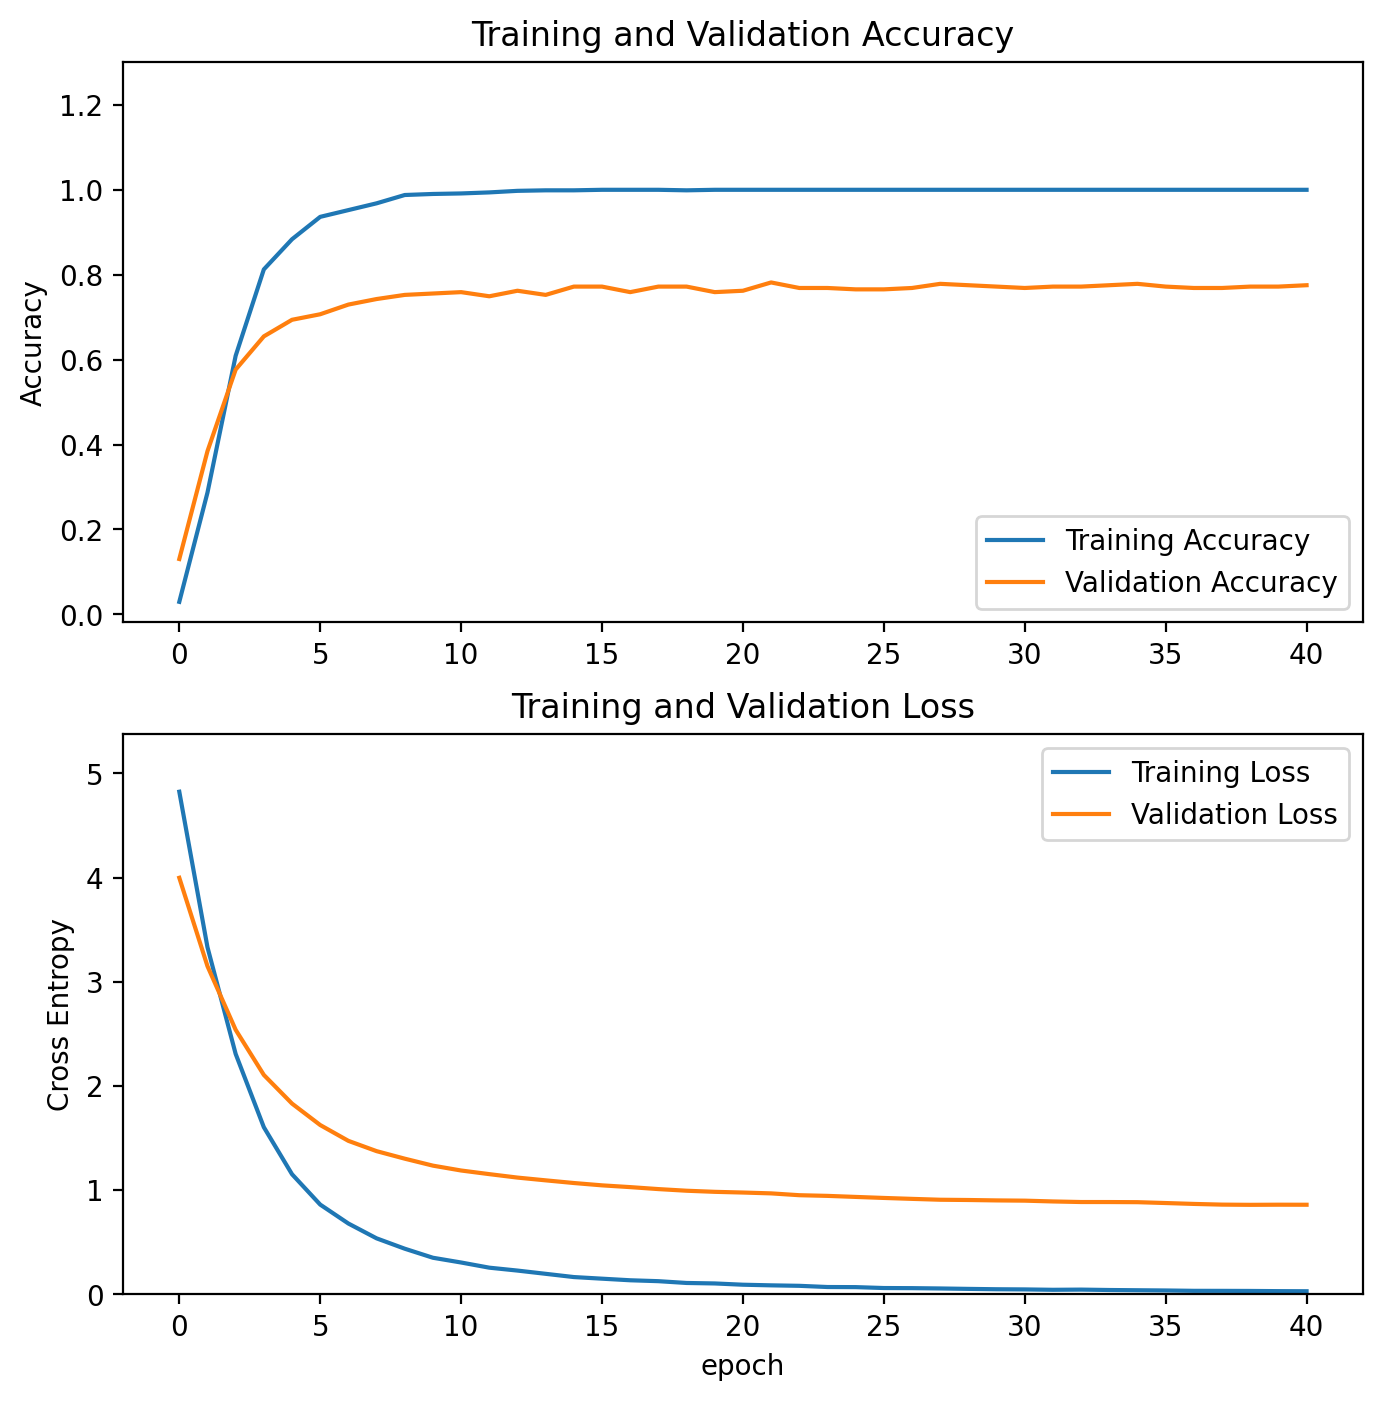

In [71]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
#plt.ylim([0,1.3])
plt.ylim([min(plt.ylim()),1.3])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, max(plt.ylim())+0.31])
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine Tuning the whole Network

In [72]:
base_model.trainable = True
modell.summary(show_trainable=True)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_11 (InputLayer) │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ mobilenetv2_1.00_224        │ (None, 7, 7, 1280)    │  2,257,984 │   Y   │
│ (Functional)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_5  │ (None, 1280)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_5 (Dropout)         │ (None, 1280)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_5 (Dense)             │ (None, 102)           │    130,662 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 2,649,972 (10.11 MB)

 Trainable params: 2,354,534 (8.98 MB)

 Non-trainable params: 34,112 (133.25 KB)

 Optimizer params: 261,326 (1020.81 KB)

In [93]:
modell.compile(optimizer = keras.optimizers.Adam(learning_rate=0.0001),
               loss= keras.losses.CategoricalCrossentropy(),
               metrics=[keras.metrics.CategoricalAccuracy()])

In [94]:
history2 = modell.fit(train_batches,
                     epochs=100,
                     validation_data= validation_batches,)
                     #callbacks=[keras.callbacks.EarlyStopping(patience=2)])

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - categorical_accuracy: 1.0000 - loss: 0.0015 - val_categorical_accuracy: 0.6417 - val_loss: 1.3436
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 220ms/step - categorical_accuracy: 1.0000 - loss: 6.9356e-04 - val_categorical_accuracy: 0.6678 - val_loss: 1.2601
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 212ms/step - categorical_accuracy: 1.0000 - loss: 4.5651e-04 - val_categorical_accuracy: 0.6808 - val_loss: 1.2065
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 227ms/step - categorical_accuracy: 1.0000 - loss: 2.7118e-04 - val_categorical_accuracy: 0.6775 - val_loss: 1.2126
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 282ms/step - categorical_accuracy: 1.0000 - loss: 3.5911e-04 - val_categorical_accuracy: 0.6906 - val_loss: 1.1331
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 218ms/step - categorical_accuracy: 0.9994 - loss: 0.0012 - val_categorical_accuracy: 0.7134 - val_loss: 1.1090
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 221ms/step - categorical_

In [95]:
results = modell.evaluate(test_batches)
print('test loss, test acc:', results)

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step - categorical_accuracy: 0.8335 - loss: 0.7545
test loss, test acc: [0.6872310042381287, 0.8409090638160706]


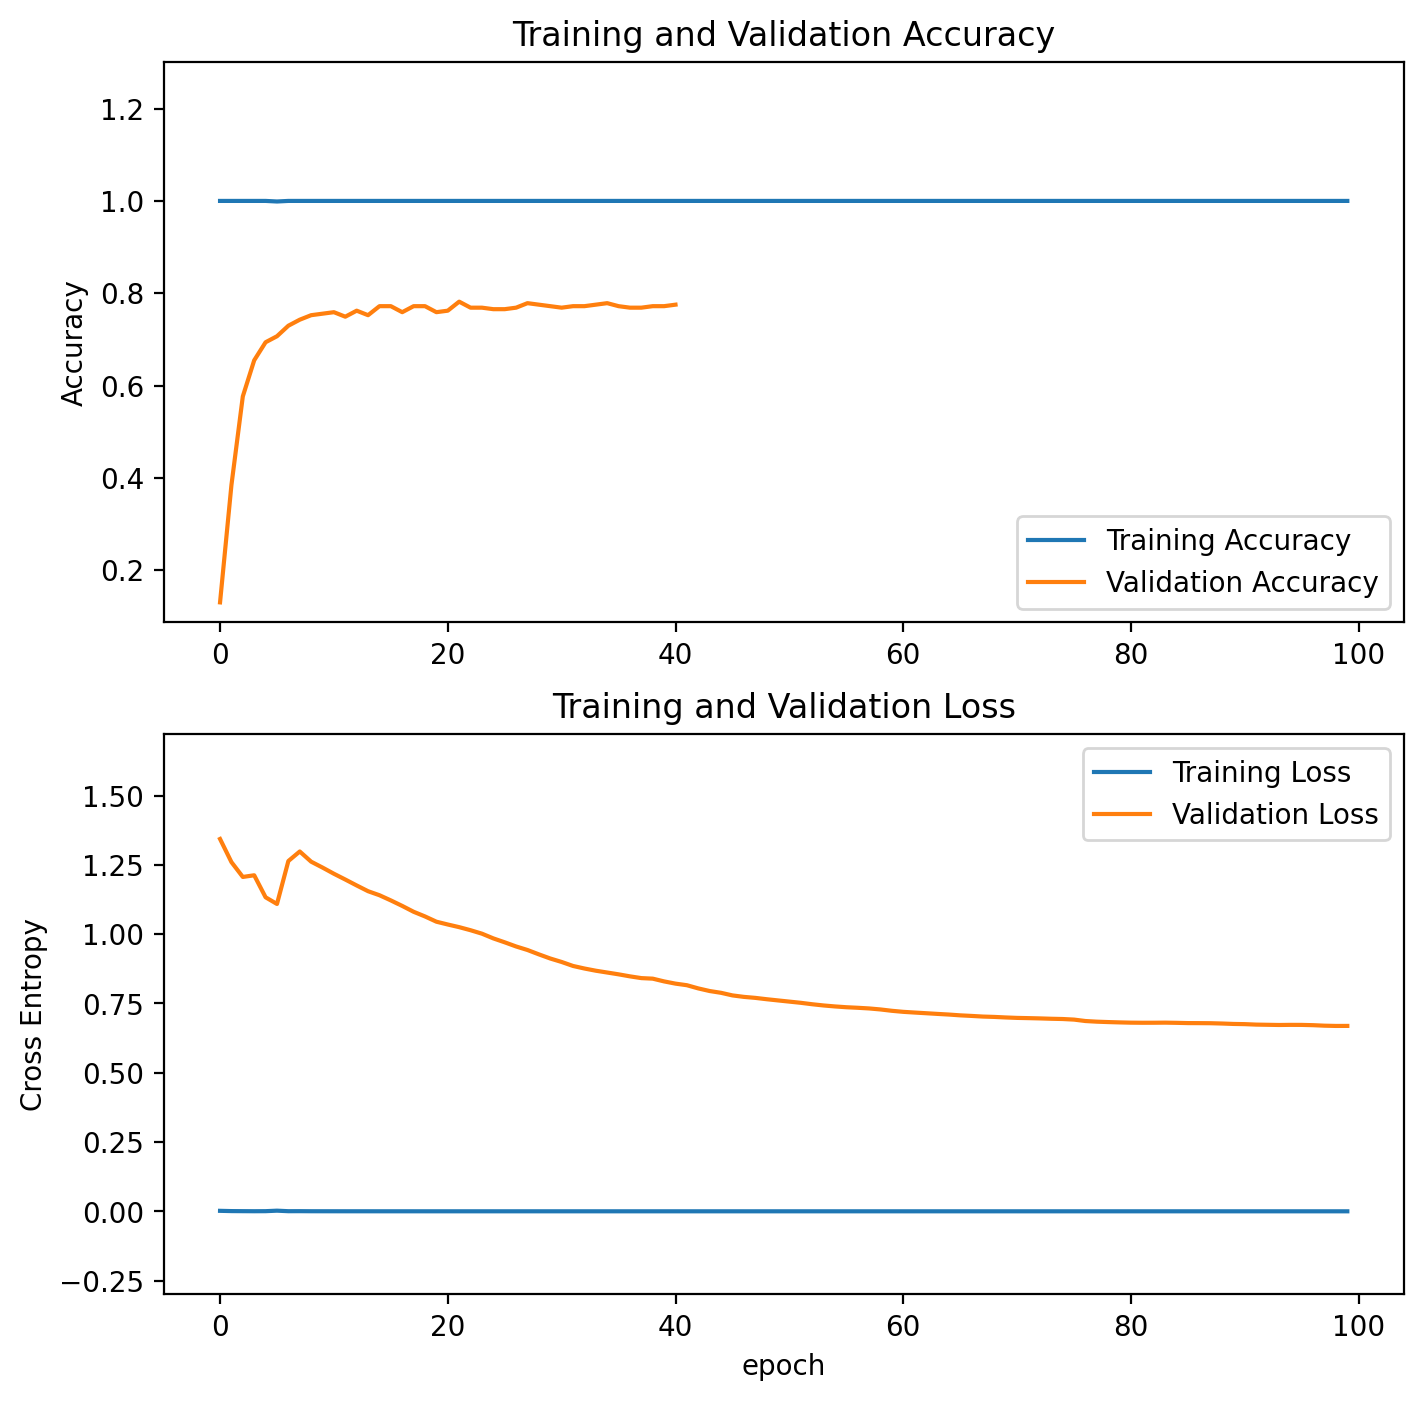

In [96]:
acc2 = history2.history['categorical_accuracy']
val_acc2 = history.history['val_categorical_accuracy']

loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc2, label='Training Accuracy')
plt.plot(val_acc2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
#plt.ylim([0,1.3])
plt.ylim([min(plt.ylim()),1.3])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss2, label='Training Loss')
plt.plot(val_loss2, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([-0.3, max(plt.ylim())+0.31])
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Testing our Network

It's good practice to test our trained network on test data, images the network has never seen either in training or validation. This will give we a good estimate for the model's performance on completely new images. we should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [97]:
modell.evaluate(test_batches)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - categorical_accuracy: 0.8335 - loss: 0.7545


[0.6872310042381287, 0.8409090638160706]

In [98]:
# #: Print the loss and accuracy values achieved on the entire test set.

results = modell.evaluate(test_batches)
print('test loss, test acc:', results)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - categorical_accuracy: 0.8335 - loss: 0.7545
test loss, test acc: [0.6872310042381287, 0.8409090638160706]


## **Conclusion**:  We can see a slight improvement in the accuracy of our model: 77 % before and 84% after fine tuning, on the test set.

---

## Save the Model

Now that our network is trained, let's save it so we can load it later for making inference. In the cell below save our model as a Keras model (*i.e.* save it as an HDF5 file).

In [ ]:
# #: Save our trained model as a Keras

#path_name = "./flower_image_classifier.h5"
#modell.save(path_name)

